# Wildfire Spatial Regression - 5-Minute Resolution
After the previous notebooks explaining the preprocessing methods, we are finally ready to run a regression. The regression will be broken into two-parts. 

The first model will focus on incidence i.e. will there be a fire in this location or not (long-term tendency). This model will be standard logistic regression, which by design is well-suited for binary classification.

The second model will also take into account the number of fires that occurred in that spot.

At the time of this writing, we have land cover data at the 5-second resolution. Thus, we will use that, as we've already preprocessd the fire and climatology data to the 5-minute resolution.


## Import Packages
As always, import all the packages we will use. Like before, we need to install `rasterio` to read the land cover tif.

In [ ]:
!pip install rasterio

     |████████████████████████████████| 18.1MB 210kB/s 


In [ ]:
import numpy as np
import numpy.ma as ma
import rasterio as rio
import pandas as pd

from itertools import product
from collections import defaultdict
import seaborn as sns

import os
import time

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer

import pprint

# To read things from our drive
from google.colab import drive

%matplotlib inline
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Fire Incidence
Currently, our fire data is **count** data, meaning we have the actual number of fires in each grid square. Incidence just means "Did a fire happen or not?" Thus, all values that aren't 0 will immediately get set to 1.

If you recall, with the count data we had about half of all squares had no fire recorded. Setting the rest to 1 actually balances out our data, which helps with model-fitting.

## Logistic Regression Variables
Since we have 0/1 target data, it makes sense to utilize logistic regression. The response variable will be the incidence value of the center cell. The input variables will be the respective incidence, climatology, and land cover values of cells surrounding the center cell. 

We can vary the **lag** as to how far out we want to go. This is a hyperparameter we can tune later.

A note about masked values: Since we will have masked cells surrounding coastal cells, we will take the average/percentage of the values. For fire incidence, the percentage of surrounding cells that had a fire occur. For climatology, the average of the surrounding cells will be taken for each metric. For land cover, the percentage of each type of land will be taken.

For those keeping score, for each lag, we have one incidence value (% of incidences), 7 climatology metrics (averaged), and 16 separate land cover categories (% of each land cover at that lag) for a total of 24 variables per lag. Thus, with a lag of 2, we will have 48 variables. It is possible to vary the lag at each level, but that is a tuning step that we can do after a basic model is trained.

A final note on lag: For corner and edge pixels, we won't have pixels in each direction. In this case, we'll just take what's available, since we are aggregating anyway.

## Reading in Data
For the 5 minute resolution, we have 9 files to read. The fires, 7 metrics, and the land cover. Now, unfortunately, masked arrays are not able to be stored this way, so instead, just like how we can index with the month from an `.npz` file, we'll store each month's data in its own dictinary. The months are the keys, and the values are **masked** arrays.

For metrics, it will be a double-level dictionary, with top-level keys being each metric, and top-level values being a dictionaries themselves.


### Fires and Metrics

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
metricNames = ['tmin', 'tmax', 'tavg', 'prec', 'srad', 'wind', 'vapr']
GDRIVE_ROOT = '/gdrive/My Drive/Data Science and Public Policy/Final project'
PREPPED_DATA = 'Data/Preprocessed/5m'
LANDCOVER = 'Data/Land Cover'

In [ ]:
# Read in common mask
maskFile = np.load(os.path.join(GDRIVE_ROOT, PREPPED_DATA, 'mask.npy'))
# Read in fires...
firesFile = np.load(os.path.join(GDRIVE_ROOT, PREPPED_DATA, 'fires.npz'))
# Create a dictionary, with month keys...
fires = {}
fires = {month : ma.core.MaskedArray(firesFile[month], mask=maskFile, dtype=int) \
         for month in months}
# For each month, force all cells > 0 to be 1.
# Make sure to use the masked version of 'where'!!
# The regular np.where function erroneously changes the mask
for month in months:
  fires[month][ma.core.where(fires[month] > 0)] = 1

### METRICS
# Function that reads a metric and stores in dictionary (like fires)
def getMetricData(metricName):
  metricFile = np.load(os.path.join(GDRIVE_ROOT, PREPPED_DATA, '{}.npz'.format(metricName)))
  return {month : ma.core.MaskedArray(metricFile[month], mask=maskFile) for month in months}

metricData = {metric : getMetricData(metric) for metric in metricNames}

In [ ]:
metricData['tavg']['Jan']

masked_array(
  data=[[3.5299999713897705, 3.961538553237915, 3.7055554389953613, ...,
         --, --, --],
        [--, --, --, ..., --, --, --],
        [2.5647058486938477, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

### Land Cover
As of this writing, the land cover hasn't been converted to a `numpy` readable format. So we have to do it the old-fashioned way, using `rasterio`.

In [ ]:
lcFile = 'nlcd2013_5min.tif'
with rio.open(os.path.join(GDRIVE_ROOT, LANDCOVER, lcFile), 'r') as lc:
  dataArray = lc.read()[0]  # <-- [0] because there's one level
  noDataVal = lc.nodata
  dataMask = lc.dataset_mask()
# Both 0 and 255 in original are missing data...
dataArray[np.where(dataArray == 0)] = 255
# Fix the mask (0 in mask means missing)
dataMask[np.where(dataArray == 255)] = 0
# Create masked array...
dataMask = ~dataMask.astype(bool)
landCoverData = ma.core.MaskedArray(dataArray, mask=dataMask)
landCoverData.fill_value = noDataVal
landCoverData

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255,
  dtype=uint8)

You'll notice that the masks aren't exaclty the same. To fix this, we'll do a bitwise OR on both the masks, and apply them to each of the fire, metrics, and land cover afterwards. That way, each point that has data in one dataset also has data in the other two.

In [ ]:
# Fire and metrics have the same mask, so just use
# one...
newMask = landCoverData.mask | fires['Jan'].mask
# Apply mask to all data...
# Fires...
for month in months:
  fires[month].mask = newMask
for metric, month in product(metricNames, months):
  metricData[metric][month].mask = newMask
landCoverData.mask = newMask

## Few Plots
Let's see what the mask did the data. Before, we had some data present in Canada, because the metrics covered the whole globe. That will clearly disappear because we only read land cover data for the US. Plot-wise, they should all appear to cover the same region.

Fire Data (January)


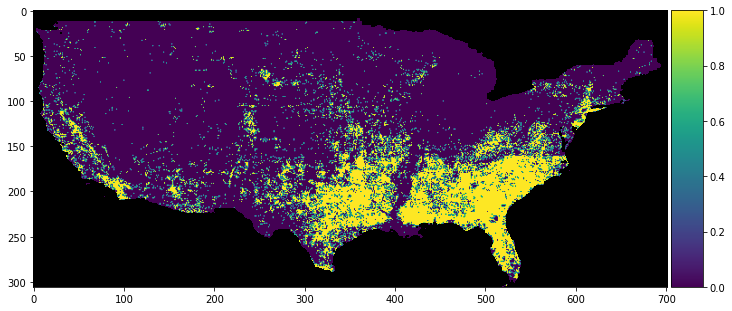

tmin


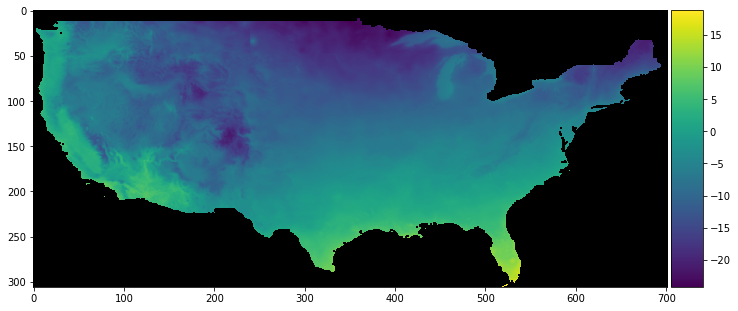

tmax


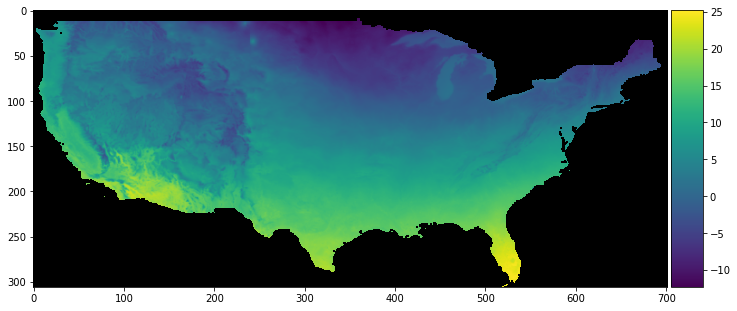

tavg


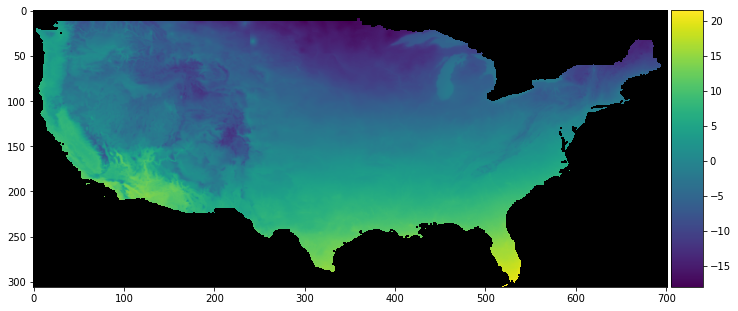

prec


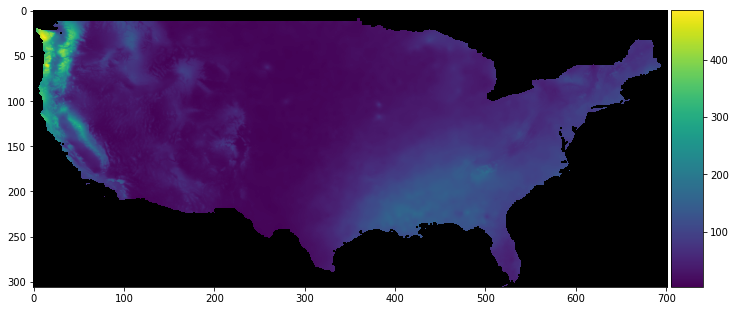

srad


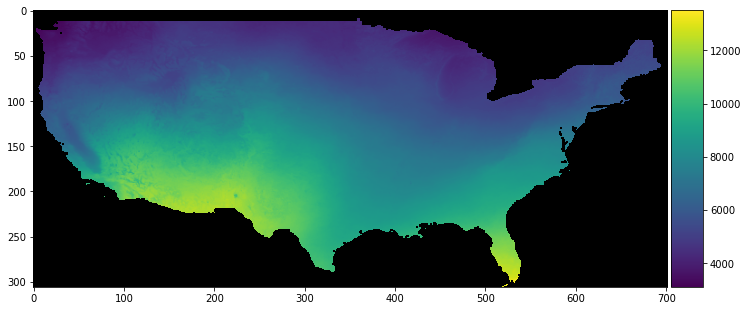

wind


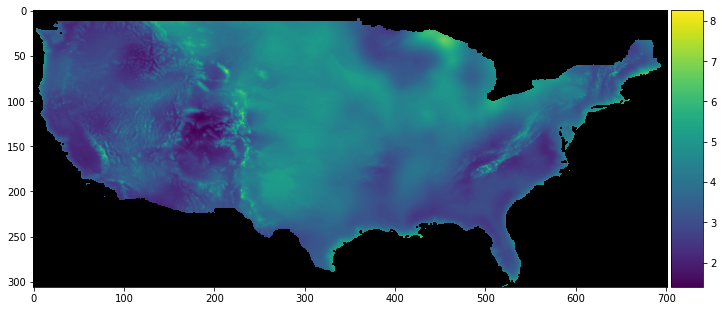

vapr


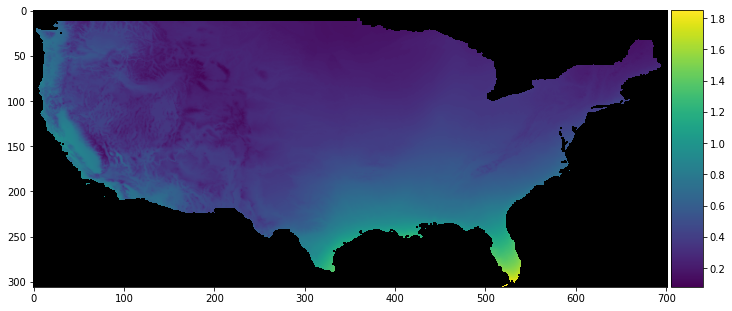

Land Cover


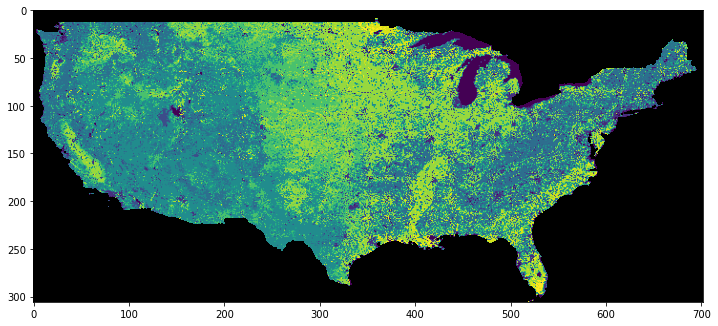

In [ ]:
# Fires...
print('Fire Data (January)')
fig, ax = plt.subplots(figsize=(12,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

currentCMap = matplotlib.cm.get_cmap()
currentCMap.set_bad(color='black')
im = ax.imshow(fires['Jan'])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

# The 7 metrics
currentCMap = matplotlib.cm.get_cmap()
currentCMap.set_bad(color='black')
for metric in metricNames:
  print(metric)
  fig, ax = plt.subplots(figsize=(12,8))
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  im = ax.imshow(metricData[metric]['Jan'])
  fig.colorbar(im, cax=cax, orientation='vertical')
  plt.show()

# Land Cover...Colors don't mean much and it's
# a pain to make it discrete for imshow (matplotlib sucks :()
print('Land Cover')
fig, ax = plt.subplots(figsize=(12,8))

currentCMap = matplotlib.cm.get_cmap()
currentCMap.set_bad(color='black')
im = ax.imshow(landCoverData)
plt.show()

Cool, all maps look exactly the same, including somehow the inclusion of Lake Michigan, half of Lake Superior, and a bit of Lake Erie.

## Setting up our Data Frame
So, as said before, in our final dataset which we'll use to run logistic regression, each row will have the percentage of cells that had fires occur, average values for metrics, and percentage values for land cover.

The key method of course, is given a cell and a lag, get all cells around it. The logic is not too difficult, though our edge cases would edge and corner. From the looks of the map, we won't have those, except for Key West probably. So we'll take care of it anyway. It's just a simple check whether we go beyond the bounds of the array when we add/subtract the lag.

### MOST IMPORTANT METHOD
This is probably the most important method/cell in this process. To get values at multiple distinct locations, we specify a tuple with the row indices, and another with column indices. For example, say we wanted the values at [5, 3], [2, 9], and [1, 0] in `arr`. To get all of them (flattened), we do `arr[(5, 2, 1), (3, 9, 0)]`. Thus, this is how we will return the values.

In [ ]:
fires['Jan'][(5, 2, 1, 1), (3, 9, 0, 0)]

masked_array(data=[--, --, --, --],
             mask=[ True,  True,  True,  True],
       fill_value=999999,
            dtype=int64)

In [ ]:
def getCellNeighbors(center, lag, width, height):
  # Local function to test whether a location
  # is within bounds...
  inBounds = lambda r, c: (0 <= r < height) and (0 <= c < width)
  # Currently, (0, 0) in array style is top corner.
  # Imagine we had a regular coordinate system instead.
  # The squares form a diamond shape. By keeping track
  # of the x and y distance from the center, we can form all 4 sides at once
  # by going along just one of them.
  # We will go along the top right side, which corresponds
  # to initial positive x and y distance.
  # Ex. lag = 2 ==> (0, 2), generates (0, -2)
  # next: (1, 1), generates (-1, 1), (1, -1), and (-1, -1)
  # next: (0, 2) generates (0, -2)
  # We'll deal with center afterwards...
  points = []
  for xdist in range(lag + 1):
    ydist = lag - xdist
    if xdist == 0:  # Only need one other point...
      points.extend([
        (xdist, ydist),
        (xdist, -ydist)   # Bottom corner
      ])
    elif ydist == 0:
      points.extend([
        (xdist, ydist),
        (-xdist, ydist)   # Left corner
      ])
    else:
      points.extend([
        (xdist, ydist),   # Top right
        (-xdist, ydist),  # Top left
        (xdist, -ydist),  # Bottom right
        (-xdist, -ydist)  # Bottom left
      ])
  # Filter out points that are outside of bounds...
  # And add the center while we're at it...
  # The array style coordinates is regular
  # Cartesian that's been rotated 90 degrees CW
  points = [(center[0] + r, center[1] + c) for r, c in points 
            if inBounds(center[0] + r, center[1] + c)]
  # (x, y) are paired, we need to unpair them.
  # Like how 'zip' pairs things, zip with a star 
  # will 'unzip' them. We also require it be a tuple...
  return tuple(zip(*points))

In [ ]:
landCoverData[getCellNeighbors((50, 50), 2, 702, 306)]

masked_array(data=[52, 71, 52, 42, 71, 82, 82, 42],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=255,
            dtype=uint8)

## Making the Data Frame
We are now ready to make our dataframe. It's quite straightforward. For each month, we go through each pixel in the fire data, grab the values at a specified lag from the requisite metrics (in the correct month), and percentages from the corresponding land cover, and that constitutes a row.

### Lag of 1 - TOO SLOW
~~Start simple, with a lag of 1. Also we won't be using `tmin` or `tmax`. Also, for center cells that are themselves masked, we'll skip those.~~ The code below is SUPER SLOW. I'll try again.

In [ ]:
# start = time.perf_counter()


# # Create empty dataframe
# spatialRegDF = pd.DataFrame(columns=colNames)

# # Notice the order we added them in (fire -> metrics -> landcover)
# # This is important as we won't create
# # the actual dataframe until we have the
# # 2D data ready (dataframes are pretty
# # bad at appending...)
# # Of course, we could do a .index()
# # on the colNames array, but given
# # the giant number of rows I'm expecting,
# # that will get seriously slow...best to hardcode.
# DATA = []
# # LET'S LOOP!!!
# for month, fireData in fires.items():
#   print('Doing {}...'.format(month))
#   # Array representing this row of data
#   row = []
#   # Loop through each point...
#   for i, j in product(range(NUMROWS), range(NUMCOLS)):
#     print('\r{}/{}'.format(i * NUMCOLS + NUMCOLS + 1, NUMROWS * NUMCOLS), end='')
#     # If it's msaked, skip it...
#     if ma.core.is_masked(fireData[i, j]):
#       continue
    
#     for lag in range(LAG + 1):
#       # Create empty dictionary initialized to 0
#       # that contains counts of each landcover...
#       landCoverCounts = defaultdict(int)
#       # Use our method to get locations at the lag distance...
#       laggedLocs = getCellNeighbors((i, j), lag, NUMCOLS, NUMROWS)
#       # % of locs that had a fire. Since it's 0/1, taking
#       # the mean gets us the answer. Luckily, mean()
#       # ignores masked values as well...
#       row.append(np.mean(fireData[laggedLocs]))
#       # Calculate average of each metric
#       for metric in metricsToUse:
#         row.append(np.mean(metricData[metric][month][laggedLocs]))
#       # Count each land cover type.
#       # np.unique() is our friend....if only it ignored
#       # the mask...otherwise I could have done this in one line...
#       totalLC = 0
#       uniques, counts = np.unique(landCoverData[laggedLocs], return_counts=True)
#       for LCunique, count in zip(uniques, counts):
#         # Don't count masked land covers...
#         if ma.core.is_masked(LCunique):
#           continue
#         landCoverCounts[LCunique] = count
#         totalLC += count
#       # Calculate percentage and append...
#       for landCoverKey in landCoverCats:
#         row.append(landCoverCounts[landCoverKey] / totalLC)
    
#     # This will probably never happen,
#     # but by chance if we had a unmasked cell value that
#     # was surrounded on all sides by masked cells, then
#     # doing a np.mean() will result in "masked". If that
#     # happens, then just ignore the row.
#     # Otherwise, append the row to DATA and move on...
#     if any(map(ma.core.is_masked, row)):
#       continue
#     DATA.append(row)
#     # If we've done 10,000 rows...append
#     # to larger dataframe and clear...
#     # if len(DATA) >= 10000:
#     #   miniDF = pd.DataFrame(data=DATA, columns=colNames)
#     #   spatialRegDF = pd.concat([spatialRegDF, miniDF], axis=0)
#     #   del DATA
#     #   DATA = []
#     #   print('Saved chunk...')

#   print('\nDone')
#   spatialRegDF = pd.DataFrame(data=DATA, columns=colNames)
#   spatialRegDF.to_csv('./January.csv', index=None)
#   print('Saved csv...')
        
# # We've added all the DATA we need...
# # Now simply create the DataFrame and we're done!
# spatialRegDF = pd.DataFrame(data=DATA, columns=colNames)
# # Save to our drive...
# spatialRegDF.to_csv(os.path.join(GDRIVE_ROOT, PREPPED_DATA, 'spatialReg.csv'), index=None)

# end = time.perf_counter()

# print('FINISHED IN', end - start, 'SECONDS.')

### Lag of 5 - ONE MORE TRY
Ok, so the main problem with the code above was that it was literally going through each element in a `numpy` array, and calling `np.mean`, and `np.unique` each time. Multiple package calls like that is pretty inefficient. The size of the data isn't the issue, it's the repeated calls to `numpy` that are slowing it down.

The solution, of course, is to call it once. To do that, I first collect **all** lagged locations for each center. I can then index each of our datasets to get the requisite values. Reshape it so that the number of rows equal however many pixels we have, and the number of columns equal however many lagged locations we have. Then, we can have a **single** call to `np.mean` and calculate the average along each row. This is lightning quick.

For the land cover, it's a tad slower because some extra processing needs to be done. Essentially, we can convert it to a `DataFrame`, and call `pd.value_counts` in each row. This function does exactly what it sounds like. It counts up all the distinct values and produces a frequency list of sorts. Doing this across all rows will result in our 16 different categories showing up on the top. Then we can divide each row by its sum to get percentages.

Now, in order for this to work, **each row must have the same number of datapoints.** Normally, for a lag of 1, there are 4 corresponding lagged squares, **other than at the edges**. To make this work, **we will have to discard those edges**. However, that's not too much of an issue because most of those values are masked anyway.

Because we need to keep the number of lagged locations constant

Let's get started!

Code below is currently commented out, as the regression is just below it. Since running takes a while, don't do it unless you really have to.

In [ ]:
# To start, tmin and tmax would likely
# be highly correlated with tavg, so just
# use tavg. The other metrics are fine.
metricsToUse = ['tavg', 'prec', 'srad', 'wind', 'vapr']
# Constant lag for each variable.
LAG = 5
# /ᐠ｡ꞈ｡ᐟ\
landCoverCats = [11, 12, 21, 22, 23, 24, 31, 
                 41, 42, 43, 52, 71, 81, 82,
                 90, 95]
# Save the shape, we'll do product() later :)
NUMROWS, NUMCOLS = fires['Jan'].shape
# Create the column names...
# We will need to reference the
# fire names, metric names, and 
# land cover names separately,
# so create a dictionary.
fireColNames = {}
metricColNames = {}
landCoverColNames = {}

for lag in range(1, LAG + 1):
  fireColNames[lag] = 'fires_L{}_%'.format(lag)
  metricColNames[lag] = ['{}_L{}_avg'.format(metric, lag) \
                         for metric in metricsToUse]
  landCoverColNames[lag] = ['LC{}_L{}_%'.format(lc, lag) \
                            for lc in landCoverCats]
# Add all columns to a big list to
# create the ultimate dataframe...
colNames = ['Month']
for lag in range(1, LAG + 1):
  colNames.append(fireColNames[lag])
  colNames.extend(metricColNames[lag])
  colNames.extend(landCoverColNames[lag])

# Add a column for incidience of fire in the center...
colNames.append('fireCenter')

In [ ]:
# Eventual dataframe...initially empty
spatialReg = pd.DataFrame(data=None, columns=colNames)

# The locations we can lag is determined by our
# LARGEST lag. The list of center locations we can
# gather stay constant throughout the process
laggable = np.ones((NUMROWS, NUMCOLS), dtype=bool)
laggable[-LAG:, :] = False
laggable[:LAG, :] = False
laggable[:, :LAG] = False
laggable[:, -LAG:] = False
# Where values aren't masked and are laggable
rows, cols = np.where(~fires['Jan'].mask & laggable)
# Get lagged locations for each cell...
# at each possible lag....
allLocs = {
    lag: [getCellNeighbors((i, j), lag, NUMCOLS, NUMROWS) \
          for i, j in zip(rows, cols)] \
      for lag in range(1, LAG + 1)
}

In [ ]:
# start = time.perf_counter()

# for month in months:
#   print('Doing {}...'.format(month), end='')
#   # Create dataframe for this month,
#   # we know how many values there are.
#   # Doesn't matter which allLocs list we take...
#   spatialMonth = pd.DataFrame(np.zeros((len(allLocs[1]), len(colNames))), 
#                             columns=colNames)
#   for lag in range(1, LAG + 1):
#     # Get values of fires for each cell at that lag...
#     fireIncidences = ma.core.asarray([fires[month][locs] for locs in allLocs[lag]])
#     # 0/1 data ==> percentage = mean. Take avg across each row
#     # and assign to dataframe
#     spatialMonth[fireColNames[lag]] = ma.core.mean(fireIncidences, axis=1)
#     # Collect ALL metrics into a 3D array.
#     # ma.core.asarray is called twice to ensure the mask
#     # is propagated throughout.
#     collectedMets = ma.core.asarray([ma.core.asarray([metricData[metric][month][locs] for locs in allLocs[lag]]) \
#                                     for metric in metricsToUse])
#     # The array is (numOfMetrics, numOfPoints, numOfLaggedPoints)
#     # So take average along axis 2. We also need to transpose it
#     # to convert to (numOfPoints, numOfMetrics) to assign to our df
#     spatialMonth.loc[:, metricColNames[lag]] = ma.core.mean(collectedMets, axis=2).T
#     # Grab Land Cover values, and convert to an object (important!)
#     # dataframe
#     lcs = ma.core.asarray([landCoverData[locs] for locs in allLocs[lag]])
#     lcsdf = pd.DataFrame(lcs, dtype=object)
#     # value_counts only work on object data. Call it
#     # on each row and collect it.
#     countsPerCat = lcsdf.apply(pd.value_counts, axis=1)
#     # Masked data automatically became NaN. Change those to 0
#     countsPerCat = countsPerCat.fillna(0)
#     # Divide each row by each corresponding sum to get
#     # percentages for each category for each point.
#     # Assign to dataframe
#     spatialMonth.loc[:, landCoverColNames[lag]] = countsPerCat.div(countsPerCat.sum(axis=1), axis=0).values
#     # Don't forget the targets!
#     spatialMonth['fireCenter'] = fires[month][rows, cols]
#     spatialMonth.loc[:, 'Month'] = month
#   # We've added data for each lag
#   # for this month. Add it to the DataFrame!
#   spatialReg = pd.concat([spatialReg, spatialMonth])
#   print('Done')
# filepath = os.path.join(GDRIVE_ROOT, PREPPED_DATA, 'spatialReg.csv')
# print('Saving and uploading to {}...'.format(filepath), end='')
# spatialReg.to_csv(filepath, index=None)
# print('Done')
# end = time.perf_counter()
# print('FINISHED IN', end - start, 'SECONDS.')

In [ ]:
spatialReg.head()

,Month,fires_L1_%,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,LC23_L1_%,LC24_L1_%,LC31_L1_%,LC41_L1_%,LC42_L1_%,LC43_L1_%,LC52_L1_%,LC71_L1_%,LC81_L1_%,LC82_L1_%,LC90_L1_%,LC95_L1_%,fires_L2_%,tavg_L2_avg,prec_L2_avg,srad_L2_avg,wind_L2_avg,vapr_L2_avg,LC11_L2_%,LC12_L2_%,LC21_L2_%,LC22_L2_%,LC23_L2_%,LC24_L2_%,LC31_L2_%,LC41_L2_%,LC42_L2_%,LC43_L2_%,LC52_L2_%,...,vapr_L4_avg,LC11_L4_%,LC12_L4_%,LC21_L4_%,LC22_L4_%,LC23_L4_%,LC24_L4_%,LC31_L4_%,LC41_L4_%,LC42_L4_%,LC43_L4_%,LC52_L4_%,LC71_L4_%,LC81_L4_%,LC82_L4_%,LC90_L4_%,LC95_L4_%,fires_L5_%,tavg_L5_avg,prec_L5_avg,srad_L5_avg,wind_L5_avg,vapr_L5_avg,LC11_L5_%,LC12_L5_%,LC21_L5_%,LC22_L5_%,LC23_L5_%,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%,LC95_L5_%,fireCenter


In [ ]:
spatialReg.tail()

,Month,fires_L1_%,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,LC23_L1_%,LC24_L1_%,LC31_L1_%,LC41_L1_%,LC42_L1_%,LC43_L1_%,LC52_L1_%,LC71_L1_%,LC81_L1_%,LC82_L1_%,LC90_L1_%,LC95_L1_%,fires_L2_%,tavg_L2_avg,prec_L2_avg,srad_L2_avg,wind_L2_avg,vapr_L2_avg,LC11_L2_%,LC12_L2_%,LC21_L2_%,LC22_L2_%,LC23_L2_%,LC24_L2_%,LC31_L2_%,LC41_L2_%,LC42_L2_%,LC43_L2_%,LC52_L2_%,...,vapr_L4_avg,LC11_L4_%,LC12_L4_%,LC21_L4_%,LC22_L4_%,LC23_L4_%,LC24_L4_%,LC31_L4_%,LC41_L4_%,LC42_L4_%,LC43_L4_%,LC52_L4_%,LC71_L4_%,LC81_L4_%,LC82_L4_%,LC90_L4_%,LC95_L4_%,fires_L5_%,tavg_L5_avg,prec_L5_avg,srad_L5_avg,wind_L5_avg,vapr_L5_avg,LC11_L5_%,LC12_L5_%,LC21_L5_%,LC22_L5_%,LC23_L5_%,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%,LC95_L5_%,fireCenter


In [ ]:
spatialReg.shape

(0, 112)

In [ ]:
np.mean(spatialReg['fireCenter'])

nan

## Logistic Regression
The star of the show. We have data up to a lag of 5, and the goal here is to compare how well we can model our fire incidences using data at a lag of 1, and up to a lag of 5. The columns have modularly named, so it's simple to extract the proper columns.

Additionally, there are two areas we should take note of. 

1. **Class Imbalance** - Currently, just under 20% of locations have been recorded as fire. Due to this extreme, if our logistic model does not get an accuracy above 80%, then it is not a useful model. With imbalances like this, it's also useful to note the precision, recall, and F1 score. To fix imbalance, the straightforward method is to just throw away the extra records that don't have a fire, until our distirbution becomes 50-50. 
2. **Scaling the metric values** - Generally, models work much better if the independent variables are small. However, our metric data clearly doesn't follow this pattern, especially for solar radiation. However, we can't just standardize these (subtract mean, divide by standard deviation). If the variables' distributions are slightly skewed, then stardardizing like this isn't the best method.

The hope is that the performance increases as we implement points 1 and 2, as well as both of them.

Before we get started, since we're using `sklearn`'s implementation of logistic regression, we don't get access to deeper statistics. However, with the help of the training data and the coefficients, we can back out the standard errors and subsequently the Wald statistics to see how significant the coefficients are.

In [ ]:
def showStdErrWald(logModel, trainData):
  # Calculate matrix of predicted class probabilities.
  # Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
  predProbs = logModel.predict_proba(trainData)

  # Design matrix -- add column of 1's at the beginning of your X_train matrix
  X_design = np.hstack([np.ones((trainData.shape[0], 1)), trainData])

  # Initiate matrix of 0's, fill diagonal with each predicted observation's variance
  V = np.diagflat(np.product(predProbs, axis=1))
  del predProbs

  # Covariance matrix
  # Note that the @-operater does matrix multiplication in Python 3.5+, so if you're running
  # Python 3.5+, you can replace the covLogit-line below with the more readable:
  covLogit = np.linalg.inv(X_design.T @ V @ X_design)
  del X_design
  del V
  # covLogit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
  print("Covariance matrix: ", covLogit)

  # Standard errors
  print("Standard errors: ", np.sqrt(np.diag(covLogit)))

  # Wald statistic (coefficient / s.e.) ^ 2
  logitParams = np.insert(logModel.coef_, 0, logModel.intercept_)
  print("Wald statistics: ", (logitParams / np.sqrt(np.diag(covLogit))) ** 2)

In [ ]:
spatialReg = pd.read_csv(os.path.join(GDRIVE_ROOT, PREPPED_DATA, 'spatialReg.csv'))
spatialReg.dropna(inplace=True)
spatialReg.head()

,Month,fires_L1_%,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,LC23_L1_%,LC24_L1_%,LC31_L1_%,LC41_L1_%,LC42_L1_%,LC43_L1_%,LC52_L1_%,LC71_L1_%,LC81_L1_%,LC82_L1_%,LC90_L1_%,LC95_L1_%,fires_L2_%,tavg_L2_avg,prec_L2_avg,srad_L2_avg,wind_L2_avg,vapr_L2_avg,LC11_L2_%,LC12_L2_%,LC21_L2_%,LC22_L2_%,LC23_L2_%,LC24_L2_%,LC31_L2_%,LC41_L2_%,LC42_L2_%,LC43_L2_%,LC52_L2_%,...,vapr_L4_avg,LC11_L4_%,LC12_L4_%,LC21_L4_%,LC22_L4_%,LC23_L4_%,LC24_L4_%,LC31_L4_%,LC41_L4_%,LC42_L4_%,LC43_L4_%,LC52_L4_%,LC71_L4_%,LC81_L4_%,LC82_L4_%,LC90_L4_%,LC95_L4_%,fires_L5_%,tavg_L5_avg,prec_L5_avg,srad_L5_avg,wind_L5_avg,vapr_L5_avg,LC11_L5_%,LC12_L5_%,LC21_L5_%,LC22_L5_%,LC23_L5_%,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%,LC95_L5_%,fireCenter
0,Jan,0.0,-17.597000,20.500000,4540.000000,3.476000,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,-17.271333,20.00,4475.333333,3.450667,0.160000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.16275,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,-16.989799,17.200000,4412.400000,3.440000,0.167200,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.2,0
1,Jan,0.0,-17.503332,20.666667,4530.333333,3.450667,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,-17.245501,20.00,4444.250000,3.427500,0.160000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.16665,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.250000,0.0,-17.000500,16.750000,4403.250000,3.435000,0.168575,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.0,0
2,Jan,0.0,-17.349333,20.666667,4468.666667,3.417334,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,-17.318499,20.00,4461.500000,3.438000,0.160300,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.16575,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.0,-16.946800,17.000000,4424.200000,3.419200,0.167920,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.2,0
3,Jan,0.0,-17.171000,20.500000,4449.000000,3.400000,0.16,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,-17.244334,20.00,4463.666667,3.417334,0.162533,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.16586,0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200000,0.000000,0.0,-16.937601,17.200000,4415.600000,3.414400,0.166600,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.2,0.0,0
4,Jan,0.0,-17.441666,20.000000,4490.666667,3.484000,0.16,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,-17.219749,19.25,4469.750000,3.440500,0.160000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.16600,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0.0,-17.021666,16.166667,4386.333333,3.456667,0.165417,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.5,0.0,0


One thing we need to worry about is multicollinearity, especially with our land cover categories. We have listed all categories present, but what happens if everything except the last category is a 0? Then this directly determines the value of the last category (1), since each row needs to add to 1. Therefore, it's common practice to remove one category column when fitting data. Let's remove the last one i.e. `LC95`. We need to remove it for each lag.

In [ ]:
for lag in range(1, LAG + 1):
  spatialReg.drop('LC95_L{}_%'.format(lag), axis=1, inplace=True)
spatialReg.head()

,Month,fires_L1_%,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,LC23_L1_%,LC24_L1_%,LC31_L1_%,LC41_L1_%,LC42_L1_%,LC43_L1_%,LC52_L1_%,LC71_L1_%,LC81_L1_%,LC82_L1_%,LC90_L1_%,fires_L2_%,tavg_L2_avg,prec_L2_avg,srad_L2_avg,wind_L2_avg,vapr_L2_avg,LC11_L2_%,LC12_L2_%,LC21_L2_%,LC22_L2_%,LC23_L2_%,LC24_L2_%,LC31_L2_%,LC41_L2_%,LC42_L2_%,LC43_L2_%,LC52_L2_%,LC71_L2_%,...,srad_L4_avg,wind_L4_avg,vapr_L4_avg,LC11_L4_%,LC12_L4_%,LC21_L4_%,LC22_L4_%,LC23_L4_%,LC24_L4_%,LC31_L4_%,LC41_L4_%,LC42_L4_%,LC43_L4_%,LC52_L4_%,LC71_L4_%,LC81_L4_%,LC82_L4_%,LC90_L4_%,fires_L5_%,tavg_L5_avg,prec_L5_avg,srad_L5_avg,wind_L5_avg,vapr_L5_avg,LC11_L5_%,LC12_L5_%,LC21_L5_%,LC22_L5_%,LC23_L5_%,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%,fireCenter
0,Jan,0.0,-17.597000,20.500000,4540.000000,3.476000,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,-17.271333,20.00,4475.333333,3.450667,0.160000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4413.50,3.427250,0.16275,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-16.989799,17.200000,4412.400000,3.440000,0.167200,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0
1,Jan,0.0,-17.503332,20.666667,4530.333333,3.450667,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,-17.245501,20.00,4444.250000,3.427500,0.160000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4425.25,3.425000,0.16665,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-17.000500,16.750000,4403.250000,3.435000,0.168575,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0
2,Jan,0.0,-17.349333,20.666667,4468.666667,3.417334,0.16,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,-17.318499,20.00,4461.500000,3.438000,0.160300,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4414.00,3.427250,0.16575,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.0,-16.946800,17.000000,4424.200000,3.419200,0.167920,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0
3,Jan,0.0,-17.171000,20.500000,4449.000000,3.400000,0.16,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,-17.244334,20.00,4463.666667,3.417334,0.162533,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4446.80,3.421200,0.16586,0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200000,0.0,-16.937601,17.200000,4415.600000,3.414400,0.166600,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.2,0
4,Jan,0.0,-17.441666,20.000000,4490.666667,3.484000,0.16,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,-17.219749,19.25,4469.750000,3.440500,0.160000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4410.50,3.433333,0.16600,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.166667,0.0,-17.021666,16.166667,4386.333333,3.456667,0.165417,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.5,0


We need a method to show us the precision and recall, among other things, given the predictions and the targets.

In [ ]:
def reportStats(predictions, targets, return_vals=False):
  N = len(predictions)
  TP = sum((predictions == 1) & (targets == 1))
  TN = sum((predictions == 0) & (targets == 0))
  FP = sum((predictions == 1) & (targets == 0))
  FN = sum((predictions == 0) & (targets == 1))
  accuracy = (TP + TN) / N
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * precision * recall / (precision + recall)
  print('Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}'.format(accuracy, precision, recall, f1))
  if return_vals:
    return accuracy, precision, recall, f1

In order to directly compare all of our methods, we'll need to use the same records for training and testing in each run. However, because we'll be doing lag of 1 and 5, whose rows are completely different, we'll only store the indices which fall into the training and testing bucket. When we fit and evaluate, we'll index the original dataframe.

In [ ]:
trainIndices, testIndices = train_test_split(np.arange(spatialReg.shape[0]), test_size=0.2)
print('Train size:', len(trainIndices))
print('Test size:', len(testIndices))

Train size: 1170259
Test size: 292565


### Vanilla Logistic Regression
First we'll fit without doing anything to the training data. Up first is the lag of 1.

#### Lag of 1

In [ ]:
for month in months:
  print(np.mean(fires[month]), np.max(fires[month]), np.min(fires[month]),
        np.mean(spatialReg.loc[spatialReg.Month == month, 'fireCenter']))

0.19427067533553607 1 0 0.194336434184837
0.22270412973788423 1 0 0.2227609063017834
0.31506366371782996 1 0 0.3151629997867139
0.34717018258737875 1 0 0.34727896178897805
0.3172035517221589 1 0 0.31730406392019816
0.33683148996876255 1 0 0.33695919673180097
0.4098336462543761 1 0 0.40995225673081653
0.40064278628176014 1 0 0.4007727518826598
0.3306167960711328 1 0 0.3307328837918984
0.2829571448482811 1 0 0.2830470377844498
0.23182120046897162 1 0 0.23191580121737132
0.15871245972337233 1 0 0.15876687831208675


In [ ]:
# Get the correct columns corresponding
# to a lag of 1...
lag1Columns = [col for col in spatialReg.columns if 'L1' in col] + ['fireCenter']
lag1Data = spatialReg.loc[:, lag1Columns]

In [ ]:
# Use indices to grab training data...
# We don't need the last column
# are our targets...
XTrain = lag1Data.iloc[trainIndices, :-1].values
YTrain = lag1Data.iloc[trainIndices, -1].values
XTest = lag1Data.iloc[testIndices, :-1].values
YTest = lag1Data.iloc[testIndices, -1].values

In [ ]:
lag1LogRegNoScale = LogisticRegression()
lag1LogRegNoScale.fit(XTrain, YTrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lag1LogRegNoScale.predict(XTest)
reportStats(predictions, YTest)
print('All 0 accuracy:', 1 - np.mean(YTest))

Accuracy: 0.824004921983149
Precision: 0.7520457557770991
Recall: 0.6036193339500463
F1: 0.6697072332127371
All 0 accuracy: 0.7044075675490917


In [ ]:
lag1LogRegNoScale.coef_

array([[ 2.19092218e+00,  1.17489153e-01,  1.34197300e-03,
        -1.30685241e-04, -1.19011426e-01, -3.60651834e-01,
        -9.92010422e-02, -1.08467702e-04,  4.51408549e-02,
         1.96157306e-02,  1.29830252e-02,  2.05395137e-03,
        -3.69820037e-02,  1.08209204e-01,  3.03444928e-01,
         7.55194827e-02, -3.08373516e-01, -5.86614107e-02,
         6.66270589e-02, -3.20688732e-01,  1.12657383e-01]])

In [ ]:
# showStdErrWald(lag1LogRegNoScale, lag1Data.iloc[trainIndices, :-1].values)

Not bad. Our null accuracy is 70.4%, and our logistic regression accuracy using just lag 1 data is 84.4%, a 14% increase. Our recall could be a bit higher though. This shows we have more false negatives than false positives.

#### Lag of 5
Now we'll use all our data...measurements up to lag of 5 will be used...

In [ ]:
# Create training and testing sets
# using EVERYTHING.
# The first column is month, we don't need it...
XTrain = spatialReg.iloc[trainIndices, 1:-1].values
YTrain = spatialReg.iloc[trainIndices, -1].values
XTest = spatialReg.iloc[testIndices, 1:-1].values
YTest = spatialReg.iloc[testIndices, -1].values

In [ ]:
lag5LogRegNoScale = LogisticRegression(max_iter=2000)
lag5LogRegNoScale.fit(XTrain, YTrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lag5LogRegNoScale.predict(XTest)
reportStats(predictions, YTest)
print('All 0 accuracy:', 1 - np.mean(YTest))

Accuracy: 0.8476065147915848
Precision: 0.771161538361963
Recall: 0.6888644773358001
F1: 0.7276935949820131
All 0 accuracy: 0.7044075675490917


In [ ]:
lag5LogRegNoScale.coef_

array([[ 1.28979009e+00,  1.64001445e-02, -3.36370733e-02,
        -2.45629252e-05, -6.92921355e-02, -2.10994645e-01,
        -5.96602463e-02, -7.50970845e-05,  2.61350220e-02,
         1.09073640e-02,  6.86295218e-03,  8.82994286e-04,
        -2.29943702e-02,  6.19093498e-02,  1.69852623e-01,
         4.26965565e-02, -1.87731511e-01, -3.32890426e-02,
         3.86450484e-02, -1.80511805e-01,  6.54627759e-02,
         1.16107373e+00,  3.62176371e-03,  2.96412039e-02,
        -3.64347763e-04, -6.58271772e-02, -2.11501178e-01,
        -5.20605218e-02, -4.31312021e-05,  2.41312886e-02,
         8.79765258e-03,  6.00748326e-03,  5.54337181e-04,
        -2.16478825e-02,  5.88044128e-02,  1.61960737e-01,
         3.93459326e-02, -1.80717109e-01, -3.12399570e-02,
         3.91865678e-02, -1.77052119e-01,  6.31553006e-02,
         1.06800740e+00,  9.42625832e-03,  2.91163844e-02,
         7.76628725e-04, -6.53296936e-02, -2.11214264e-01,
        -4.59217486e-02, -4.78481759e-05,  2.18532169e-0

It's better....but not by much. About 0.3%. Comparing the precision and recall, it appears a false positive went down, while a false negative went up. Our class imbalance is 70-30 right now. Maybe it could be better if we rebalanced to make it 50-50.

### Fixing Class Imbalance
Only 20% of our labels are 1, so the logistic regression is assuming most places don't have fires. Which is true, except that results in the model not picking up on the effect that the variables are having. If we have fewer samples of 0, it should mitigate it. 

Fortunately, we've got a million records. Thus, all we have to do is randomly throw out 0 records until they match the number of 1 records. **We only do this to the training set.** The reason is that we want the testing set to emulate the real-world, and in the real-world, half of America isn't on fire.

#### Lag of 1
Remember, we only do this on the training data...

In [ ]:
XTrain = lag1Data.iloc[trainIndices, :-1].values
YTrain = lag1Data.iloc[trainIndices, -1].values
XTest = lag1Data.iloc[testIndices, :-1].values
YTest = lag1Data.iloc[testIndices, -1].values

In [ ]:
# Split the training into the 0 and 1 samples...
zeroXSamples = XTrain[np.where(YTrain == 0)]
oneXSamples = XTrain[np.where(YTrain == 1)]
# Randomly choose the number of 1 samples we have
# from the zeroXSamples...
indices = np.random.choice(np.arange(0, zeroXSamples.shape[0]),
                           size=oneXSamples.shape[0],
                           replace=False)
chosen0Samples = zeroXSamples[indices, :]
# Stack it on top of the oneXSamples and shuffle...
# Make sure the targets are chosen the same way...
XTrainRebalanced = np.append(chosen0Samples, oneXSamples, axis=0)
YTrainRebalanced = np.append(YTrain[YTrain == 0][indices], YTrain[YTrain == 1])
# Create a shuffle.
indices = np.arange(XTrainRebalanced.shape[0])
np.random.shuffle(indices)
XTrainRebalanced = XTrainRebalanced[indices, :]
YTrainRebalanced = YTrainRebalanced[indices]
print('New number of records:', XTrainRebalanced.shape[0])
print('New proportion of fires:', np.mean(YTrainRebalanced))

New number of records: 692298
New proportion of fires: 0.5


There we go. Our training dataset size tanked to about half a million, but that's ok since that's plenty.

In [ ]:
lag1LogRegBalanced = LogisticRegression(max_iter=500)

In [ ]:
lag1LogRegBalanced.fit(XTrainRebalanced, YTrainRebalanced)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lag1LogRegBalanced.predict(XTest)
reportStats(predictions, YTest)
print('Null accuracy:', 1 - np.mean(YTest))

Accuracy: 0.8358108454531472
Precision: 0.6953256782847271
Recall: 0.7912465309898242
F1: 0.7401914651955216
Null accuracy: 0.7044075675490917


In [ ]:
lag1LogRegBalanced.coef_

array([[ 4.56951584e+00,  7.24843256e-02, -5.87171272e-04,
        -2.78735825e-06, -1.93692506e-01, -8.77273650e-01,
        -3.62097520e-01, -6.93023205e-04,  1.09293794e-01,
         5.18348525e-02,  3.35106322e-02,  2.19032772e-03,
        -1.78238277e-01,  1.92250959e-01,  2.90705003e-01,
         1.92308050e-01, -9.80418491e-01, -2.43280912e-01,
         1.65758618e-01, -3.38854147e-01,  2.92934778e-01]])

Huh. It actually got a tad worse. There's a good chance that it got under-sensitized to it. However, on another note, **we have more false positives than false negatives now**. Thus, the rabalancing helped with classifying areas which had no fires reported, but hampered its ability to detect fires as a result.

#### Lag of 5

In [ ]:
XTrain = spatialReg.iloc[trainIndices, 1:-1].values
YTrain = spatialReg.iloc[trainIndices, -1].values
XTest = spatialReg.iloc[testIndices, 1:-1].values
YTest = spatialReg.iloc[testIndices, -1].values

In [ ]:
# Split the training into the 0 and 1 samples...
zeroXSamples = XTrain[np.where(YTrain == 0)]
oneXSamples = XTrain[np.where(YTrain == 1)]
# Randomly choose the number of 1 samples we have
# from the zeroXSamples...
indices = np.random.choice(np.arange(0, zeroXSamples.shape[0]),
                           size=oneXSamples.shape[0],
                           replace=False)
chosen0Samples = zeroXSamples[indices, :]
# Stack it on top of the oneXSamples and shuffle...
# Make sure the targets are chosen the same way...
XTrainRebalanced = np.append(chosen0Samples, oneXSamples, axis=0)
YTrainRebalanced = np.append(YTrain[YTrain == 0][indices], YTrain[YTrain == 1])
# Create a shuffle.
indices = np.arange(XTrainRebalanced.shape[0])
np.random.shuffle(indices)
XTrainRebalanced = XTrainRebalanced[indices, :]
YTrainRebalanced = YTrainRebalanced[indices]
print('New number of records:', XTrainRebalanced.shape[0])
print('New proportion of fires:', np.mean(YTrainRebalanced))

New number of records: 692298
New proportion of fires: 0.5


In [ ]:
lag5LogRegBalanced = LogisticRegression(max_iter=2000)
lag5LogRegBalanced.fit(XTrain, YTrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lag5LogRegBalanced.predict(XTest)
reportStats(predictions, YTest)
print('All 0 accuracy:', 1 - np.mean(YTest))

Accuracy: 0.8476065147915848
Precision: 0.771161538361963
Recall: 0.6888644773358001
F1: 0.7276935949820131
All 0 accuracy: 0.7044075675490917


### Scaling
One last to try is scaling. Regressions are generally more interpretable if variables are centered along their mean, as then the intercept is what happens when all variables are set to their averages. 

Outside of our metrics, the data are in percentages, so need to change anything there. However, with our metrics, some of them are highly skewed, like the precipitation. In this case, it might be more helpful to use a power transformation, such as Box-Cox or Yeo-Johnson.

I'll go for both methods on the lag 1 data, as lag 5 didn't show notable improvement.

#### Standard Scaling
Your standard issue subtract the mean and divide by standard deviation, applied to the metrics ONLY (and the train data).

In [ ]:
# Get our lag 1 training and testing data again...
XTrain = lag1Data.iloc[trainIndices, :-1].values
YTrain = lag1Data.iloc[trainIndices, -1].values
XTest = lag1Data.iloc[testIndices, :-1].values
YTest = lag1Data.iloc[testIndices, -1].values

The metrics are the 2nd through 6th columns in our data. Remember, we gather our mean and standard deviation from the training data and apply it to the testing.

In [ ]:
scaler = StandardScaler()
XTrainMetricScaled = scaler.fit_transform(XTrain[:, 1:6])
# Make a copy of XTrain (to not lose the old one),
# and replace the 2nd through 6th columns with the scaled version
XTrainScaled = np.copy(XTrain)
XTrainScaled[:, 1:6] = XTrainMetricScaled
XTestScaled = np.copy(XTest)
XTestScaled[:, 1:6] = scaler.transform(XTest[:, 1:6])

In [ ]:
lag1LogRegScaled = LogisticRegression(max_iter=300)
lag1LogRegScaled.fit(XTrainScaled, YTrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lag1LogRegScaled.predict(XTestScaled)
reportStats(predictions, YTest)
print('All 0 accuracy:', 1 - np.mean(YTest))

Accuracy: 0.8464888144514894
Precision: 0.7760452637730436
Recall: 0.6756475485661425
F1: 0.7223747001953366
All 0 accuracy: 0.7044075675490917


In [ ]:
print('Intercept:', lag1LogRegScaled.intercept_)
print('Coefficients:', lag1LogRegScaled.coef_)

Intercept: [-2.38030318]
Coefficients: [[ 4.53862247  0.58410724  0.01937285  0.00593225 -0.04169429 -0.37509735
  -0.78439423 -0.28841367  0.19861821  0.13834551  0.17331424 -0.2405094
  -1.45085955  0.08842199  0.28062584  0.26914146 -0.69765059 -0.42565169
   0.07680345 -0.59763465  0.37855077]]


Note the intercept. This is the log-odds of the probability of a fire if all values are 0. In our case, since the metrics are centered, this means that:

- There was no fire in the surroundings.
- All metrics are at their averages.
- All land cover presents are absent ==> This means that land cover #95 (Emergent Herbaceous Wetlands), which we removed, is present all around.

In [ ]:
# We can calculate it directly:
print('Probability of fire when all values are 0 = {:2.4f}%'.\
      format(1 / (1 + np.exp(-1 * lag1LogRegScaled.intercept_[0])) * 100))

Probability of fire when all values are 0 = 8.4687%


This did a tad better than the class imbalance and the law regressions. Additionally, the coefficients are much more readable.

#### Power Transformation
Another way we can transform is using a power transformation. This is designed to make the data more normal-like. There are two in practice: Box-Cox and Yeo-Johnson. The latter can handle negative and positive values, as opposed to Box-Cox which can only handle positive values. However, Yeo-Johnson has interpretability issues.

In [ ]:
pt = PowerTransformer()
XTrainMetricScaled = pt.fit_transform(XTrain[:, 1:6])
# Make a copy of XTrain (to not lose the old one),
# and replace the 2nd through 6th columns with the scaled version
XTrainScaled = np.copy(XTrain)
XTrainScaled[:, 1:6] = XTrainMetricScaled
XTestScaled = np.copy(XTest)
XTestScaled[:, 1:6] = scaler.transform(XTest[:, 1:6])

In [ ]:
lag1LogRegPT = LogisticRegression(max_iter=300)
lag1LogRegPT.fit(XTrainScaled, YTrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lag1LogRegPT.predict(XTestScaled)
reportStats(predictions, YTest)
print('All 0 accuracy:', 1 - np.mean(YTest))

Accuracy: 0.8462700596448652
Precision: 0.774113016141389
Recall: 0.6776711378353376
F1: 0.7226887647515815
All 0 accuracy: 0.7044075675490917


In [ ]:
print('Intercept:', lag1LogRegPT.intercept_)
print('Coefficients:', lag1LogRegPT.coef_)

Intercept: [-2.46855398]
Coefficients: [[ 4.59048849  0.59893066  0.03887827  0.01116212 -0.02653563 -0.39953142
  -0.71654203 -1.02321333  0.25979553  0.20015835  0.26235116 -0.14873168
  -1.29194888  0.16702497  0.3381215   0.3631697  -0.58104424 -0.3219329
   0.11665578 -0.5057458   0.39601795]]


In [ ]:
pt.inverse_transform(np.zeros(5).reshape(1, -1))

array([[1.08986945e+01, 5.30134903e+01, 1.50200553e+04, 3.59337688e+00,
        7.75430007e-01]])